In [9]:
# import Pandas libary for data manipulation 
import pandas as pd

# Read the datasets 
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Combine two dataframe for later use
combine = [train_df, test_df]

#Snapshot of the dataset
train_df.head()
#PassengerId: Unique Id of a passenger
#Survival: Whether a passenger survived or not; 1 if survived and 0 if not.
#pclass: Ticket class
#Name: name of the passenger
#sex: Sex
#Age: Age in years
#sibsp: # of siblings / spouses aboard the Titanic
#parch: # of parents / children aboard the Titanic
#ticket: Ticket number
#fare: Passenger fare
#cabin: Cabin number
#embarked: Port of Embarkation

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:

train_df.info()
#We can see that there are some missing data in 'age', 'cabin' and 'embarked'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 66.2+ KB


In [11]:
#count the number of null
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [25]:
#We can find that most of the "Embarked" is 'S'
train_df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [37]:
#Fill the NaN column by 'S' and turn them into integers
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

for dataset in combine:
    print(dataset.Embarked.unique())
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

[0 1 2]


ValueError: Cannot convert non-finite values (NA or inf) to integer

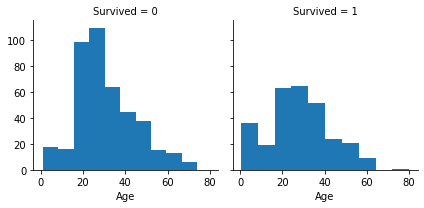

In [40]:
#For data visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Age')

In [44]:
#Fill the NaN in age
import numpy as np
for dataset in combine:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

<ipython-input-44-496dbe54a3ca>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list


In [45]:

for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Major', 'Sir', 'Jonkheer', 'Dona','Rev'], 'Other')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Dr,0.428571
1,Master,0.575000
2,Miss,0.702703
3,Mr,0.156673
4,Mrs,0.793651
5,Other,0.312500


In [46]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Other": 6}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

In [47]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

In [48]:
for dataset in combine:
    dataset['Fare'] = dataset['Fare'].fillna(train_df['Fare'].median())

In [56]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] +  dataset['Parch'] + 1


In [65]:
drop_list=['Name','SibSp',"Parch",'Ticket','Cabin']

train_df = train_df.drop(drop_list, axis =1)
test_df = test_df.drop(drop_list, axis =1)

In [68]:
list = ["PassengerId", "Survived"]
X_train = train_df.drop(list, axis=1)

y_train = train_df['Survived']
X_test = test_df.drop("PassengerId", axis=1).copy()
X_train.shape, y_train.shape, X_test.shape


((891, 7), (891,), (418, 7))

In [73]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)


array([[ 0.82737724, -0.73769513, -0.55881415, ..., -0.56883712,
        -0.68276953,  0.05915988],
       [-1.56610693,  1.35557354,  0.62490866, ...,  1.00518113,
         1.14684747,  0.05915988],
       [ 0.82737724,  1.35557354, -0.26288345, ..., -0.56883712,
         0.23203897, -0.56097483],
       ...,
       [ 0.82737724,  1.35557354, -0.26288345, ..., -0.56883712,
         0.23203897,  1.29942929],
       [-1.56610693, -0.73769513, -0.26288345, ...,  1.00518113,
        -0.68276953, -0.56097483],
       [ 0.82737724, -0.73769513,  0.18101261, ...,  2.57919938,
        -0.68276953, -0.56097483]])

In [74]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred_decision_tree = clf.predict(X_test)
acc_decision_tree = round(clf.score(X_train, y_train) * 100, 2)
print (acc_decision_tree)

98.88


In [79]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, y_train) * 100, 2)
acc_log

81.37

In [75]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": y_pred_decision_tree
    })


In [76]:
submission.to_csv('submission.csv', index=False)
